# MNIST Multi-Modal Learning Practice Notebook

In this notebook, you will practice some of the core concepts we have presented. The overall pipeline is as follows:

---

## 1. Data Preparation

- Load the **MNIST** dataset.
- Split the dataset into **train**, **validation**, and **test** sets.
- Horizontally split each image into **upper** and **lower** halves.
- Pad the removed half with zeros to maintain consistent input shapes.

---

## 2. Model Definitions

Define three encoders:

1. **CNNEncoder**  
   - A simple CNN with two convolutional layers and pooling layers.

2. **MLPEncoder**  
   - A simple MLP with two fully connected layers.

3. **FusedModel**  
   - A combined model using:
     - `CNNEncoder` for the **upper half**.
     - `MLPEncoder` for the **lower half**.

---

## 3. Training and Evaluation

For each encoder:

### (i) CNNEncoder

- Use only the **upper half** of the input data.
- Train for **5 epochs**.
- Validate using the validation set.
- Evaluate performance on the test set.

### (ii) MLPEncoder

- Use only the **lower half** of the input data.
- Train for **5 epochs**.
- Validate using the validation set.
- Evaluate performance on the test set.

### (iii) FusedModel

- Use **both upper and lower halves** of the input data.
- Use the CNNEncoder (upper half) and the MLPEncoder (bottom half) and use concatenation to fuse the representations.
- Train for **5 epochs**.
- Validate using the validation set.
- Evaluate performance on the test set.

### (iv) Different Fusion Stategies
- Explore alternative fusion strategies such as for instance average fusion (Averaging representations).

### (v) Investigate how adding noise to the representations impacts performance
- Add increasing amounts of noise to one or both modalities and monitor performance.
- Visualize the fused representations using PCA or t-SNE.

---
Concepts introduced tomorrow:

### (vi) Self-supervised:
- Instead of directly fusing modalities, align the modalities using CLIP.
- Visualize the fused representations using PCA or t-SNE.
- Train a linear classifier on-top of the learned representations (keeping the encoders frozen).

### (vii) Alignment noise:
- Add increasing amounts of noise to one or both modalities and monitor performance.
- Visualize the fused representations using PCA or t-SNE.

# Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F


# Set hyperparams and load, split MNIST

In [2]:
# Hyperparameters
batch_size = 64
learning_rate = 0.01
num_epochs = 5
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load MNIST dataset

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [0.7, 0.3])
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader  = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Visualize some images

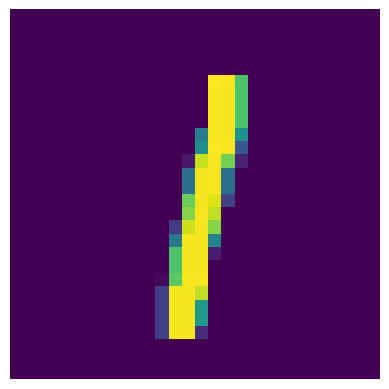

Image shape: torch.Size([28, 28, 1]), Data type: torch.float32


In [3]:
import matplotlib.pyplot as plt
import numpy as np

for images, _ in train_loader:
    # Visualize the first few images in the batch
    num_images_to_show = 1
    for i in range(num_images_to_show):
        image = images[i]  # Get one image from the batch
        image = np.transpose(image, (1, 2, 0))  # Rearrange dimensions from CxHxW to HxWxC

        # Display the image
        plt.imshow(image)
        plt.axis('off')  # Turn off axis labels
        plt.show()
    print(f"Image shape: {image.shape}, Data type: {image.dtype}")
    break  # Exit the loop after visualizing the first batch

# Define our models - a CNN, an MLP, and a FusedModel

In [ ]:
class CNNEncoder(nn.Module):
    """Simple CNN Encoder"""
    def __init__(self):
        super(CNNEncoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        #self.fc1 = nn.Linear(64*7*7, 10) #This shape depends on the kernels and the input (split) shape
        self.fc1 = None
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)  # Flatten

        if self.fc1 is None:
            # Define fc1 dynamically
            self.fc1 = nn.Linear(x.size(1), 10)
            self.fc1.to(x.device)  # move to same device
            
        x = self.fc1(x)
        return x

class MLPEncoder(nn.Module):
    """Simple 2-Layer MLP"""
    def __init__(self):
        super(MLPEncoder, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = F.relu(self.fc1(x.view(x.size(0), -1))) #Flatten all dimensions except batch_size
        x = F.relu(self.fc2(x))
        return x

# Fusing representations
# Prepare images by splitting and padding halves
def prepare_data(x):
    h = x.size(2)  # Height
    half_h = h // 2

    # Split top and bottom halves
    upper = x[:, :, :half_h, :]
    lower = x[:, :, half_h:, :]
    upper_padded = F.pad(upper, (0, 0, 0, 14))  # pad bottom
    lower_padded = F.pad(lower, (0, 0, 14, 0))  # pad top
    return upper_padded, lower_padded

class FusedModel(nn.Module):
    def __init__(self):
        super(FusedModel, self).__init__()
        self.cnn_encoder = CNNEncoder()
        self.mlp_encoder = MLPEncoder()
        self.fc = nn.Linear(20, 10)

    def forward(self, x):
        upper, lower = prepare_data(x)
        cnn_out = self.cnn_encoder(upper)  # shape [B, 10]
        mlp_out = self.mlp_encoder(lower)  # shape [B, 10]
        fused = torch.cat([cnn_out, mlp_out], dim=1)  # shape [B, 20]
        return self.fc(fused)
    

# Utils

In [ ]:
def train_model(model: nn.Module, data_loader, optimizer: optim.Optimizer, criterion: nn.modules.loss._Loss):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for x, y in data_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        preds = model(x)
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * y.size(0)
        correct += (preds.argmax(1) == y).sum().item()
        total += y.size(0)
    #print(f"Train Loss: {total_loss / total:.4f} | Accuracy: {correct / total:.4f}")
    return total_loss / total, correct / total


def evaluate_model(model: nn.Module, data_loader, criterion):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for x, y in data_loader:
            x, y = x.to(device), y.to(device)
            preds = model(x)
            loss = criterion(preds, y)
            total_loss += loss.item() * y.size(0)
            correct += (preds.argmax(1) == y).sum().item()
            total += y.size(0)
    avg_loss = total_loss / total
    accuracy = correct / total
    #print(f"Eval Loss: {avg_loss:.4f} | Accuracy: {accuracy:.4f}")
    return avg_loss, accuracy


In [6]:
for images, _ in train_loader:
  upper_half, lower_half = prepare_data(images)
  print(upper_half.shape, lower_half.shape)
  print(images.shape)
  break

torch.Size([64, 1, 28, 28]) torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])


# Check that split works

Original image shape: torch.Size([64, 1, 28, 28])
Upper half shape: torch.Size([64, 1, 28, 28])
Lower half shape: torch.Size([64, 1, 28, 28])


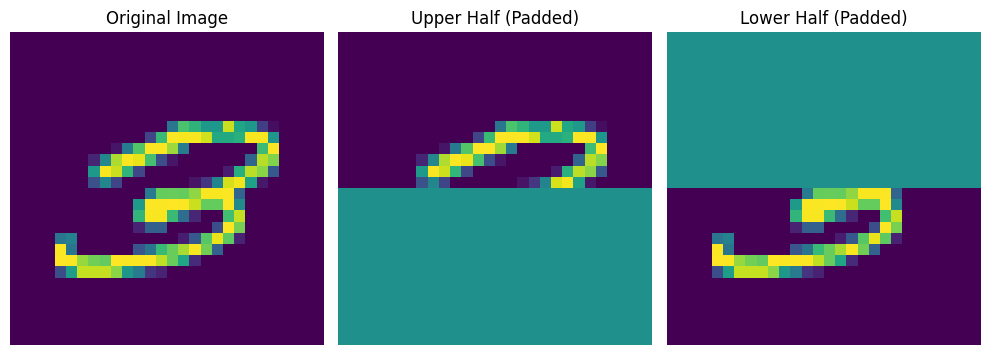

In [7]:
import matplotlib.pyplot as plt
import numpy as np

def show_split_visual_example():
    for images, _ in train_loader:
        # Use your existing prepare_data function
        upper_half, lower_half = prepare_data(images)

        # Print shapes for debugging
        print(f"Original image shape: {images.shape}")        # Should be [B, 1, 28, 28]
        print(f"Upper half shape: {upper_half.shape}")        # Should be [B, 1, 28, 28]
        print(f"Lower half shape: {lower_half.shape}")        # Should be [B, 1, 28, 28]
        
        # Take the first sample in batch
        full_img = images[0].cpu().numpy()
        upper_img = upper_half[0].cpu().numpy()
        lower_img = lower_half[0].cpu().numpy()

        # Transpose to HWC for matplotlib
        full_img  = np.transpose(full_img, (1, 2, 0))
        upper_img = np.transpose(upper_img, (1, 2, 0))
        lower_img = np.transpose(lower_img, (1, 2, 0))

        # Plot
        fig, axes = plt.subplots(1, 3, figsize=(10, 4))
        titles = ['Original Image', 'Upper Half (Padded)', 'Lower Half (Padded)']
        images_to_show = [full_img, upper_img, lower_img]

        for ax, img, title in zip(axes, images_to_show, titles):
            ax.imshow(img.squeeze())
            ax.set_title(title)
            ax.axis('off')

        plt.tight_layout()
        plt.show()
        break  # Only show one batch
show_split_visual_example()

# Init and train models

In [8]:
import pandas as pd
from tqdm import tqdm

def run_training(name, model):
    #print(f"\nTraining {name}...")
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    epoch_bar = tqdm(range(num_epochs), desc=f"{name} Training", ncols=100)

    for epoch in epoch_bar:
        train_loss, train_acc = train_model(model, train_loader, optimizer, criterion)
        val_loss, val_acc = evaluate_model(model, val_loader, criterion)

        # Update tqdm bar description
        epoch_bar.set_postfix({
            "Train Acc": f"{train_acc:.4f}",
            "Val Acc": f"{val_acc:.4f}"
        })

    test_loss, test_acc = evaluate_model(model, test_loader, criterion)
    print(f"Final Test: {test_loss:.4f} | Accuracy: {test_acc:.4f}")
    return {
        "Model": name,
        "Test Accuracy": f"{test_acc:.4f}",
        "Test Loss": f"{test_loss:.4f}"
    }

# === Run All Models ===
results = []
results.append(run_training("CNN Encoder", CNNEncoder()))
results.append(run_training("MLP Encoder", MLPEncoder()))
results.append(run_training("Fused Model", FusedModel()))

# === Display Results as Table ===
df = pd.DataFrame(results)
print("\nModel Comparison:")
print(df.to_string(index=False))


CNN Encoder Training: 100%|█████████| 5/5 [01:28<00:00, 17.60s/it, Train Acc=0.9754, Val Acc=0.9718]


Final Test: 0.0778 | Accuracy: 0.9749


MLP Encoder Training: 100%|█████████| 5/5 [00:14<00:00,  2.88s/it, Train Acc=0.1976, Val Acc=0.2008]


Final Test: 1.8881 | Accuracy: 0.1948


Fused Model Training: 100%|█████████| 5/5 [01:31<00:00, 18.23s/it, Train Acc=0.9681, Val Acc=0.9646]


Final Test: 0.1148 | Accuracy: 0.9657

Model Comparison:
      Model Test Accuracy Test Loss
CNN Encoder        0.9749    0.0778
MLP Encoder        0.1948    1.8881
Fused Model        0.9657    0.1148


## (iv) Different Fusion Stategies


In [10]:
class FusionStrategy(nn.Module):
    def __init__(self, method='concat'):
        super(FusionStrategy, self).__init__()
        self.method = method
        if method == 'concat':
            self.fc = nn.Linear(20, 10)  # For concatenation of two 10-d vectors
        elif method == 'gated':
            self.gate_layer = nn.Sequential(nn.Linear(20, 10),nn.Sigmoid())
            self.fc = nn.Linear(10, 10)
        elif method == 'weighted_sum':   
            self.alpha = nn.Parameter(torch.tensor(0.5)) # Learnable scalar initialized to 0.5

    def forward(self, x1, x2):
        if self.method == 'concat':
            return self.fc(torch.cat((x1, x2), dim=1))
        elif self.method == 'sum':
            return x1 + x2
        elif self.method == 'multiply':
            return x1 * x2
        elif self.method == 'average':
            return (x1 + x2) / 2
        elif self.method == 'weighted_sum':
            return self.alpha * x1 + (1 - self.alpha) * x2
        elif self.method == 'gated':
            combined = torch.cat((x1, x2), dim=1)
            gate = self.gate_layer(combined)
            return self.fc(gate * x1 + (1 - gate) * x2)
        else:
            raise ValueError(f"Unknown fusion method {self.method}")

class FusedModels(nn.Module):
    def __init__(self, fusion_method='concat'):
        super(FusedModels, self).__init__()
        self.cnn_encoder = CNNEncoder()
        self.mlp_encoder = MLPEncoder()
        self.fusion = FusionStrategy(fusion_method)
        
    def forward(self, x):
        upper, lower = prepare_data(x)
        cnn_out = self.cnn_encoder(upper)
        mlp_out = self.mlp_encoder(lower)
        return self.fusion(cnn_out, mlp_out)
    

# List of fusion strategies to test
fusion_methods = [
    ("CNN Encoder", CNNEncoder()),
    ("MLP Encoder", MLPEncoder()),
    ("Concat Fusion", FusedModels('concat')),
    ("Sum Fusion", FusedModels('sum')),
    ("Multiply Fusion", FusedModels('multiply')),
    ("Average Fusion", FusedModels('average')),
    ("Weighted Sum Fusion", FusedModels('weighted_sum')),
    ("Gated Fusion", FusedModels('gated')),
]

results = []
for name, model in fusion_methods:
    result = run_training(name, model)
    results.append(result)
    # Free up memory after each model to avoid GPU OOM
    del model
    torch.cuda.empty_cache()

# Display comparison table
df = pd.DataFrame(results)
print("\nModel Comparison:")
print(df.to_string(index=False))


CNN Encoder Training: 100%|█████████| 5/5 [01:28<00:00, 17.77s/it, Train Acc=0.9769, Val Acc=0.9633]


Final Test: 0.1114 | Accuracy: 0.9661


MLP Encoder Training: 100%|█████████| 5/5 [00:14<00:00,  2.83s/it, Train Acc=0.6384, Val Acc=0.6258]


Final Test: 0.9597 | Accuracy: 0.6339


Concat Fusion Training: 100%|███████| 5/5 [01:31<00:00, 18.25s/it, Train Acc=0.9671, Val Acc=0.9619]


Final Test: 0.1289 | Accuracy: 0.9620


Sum Fusion Training: 100%|██████████| 5/5 [01:30<00:00, 18.09s/it, Train Acc=0.9240, Val Acc=0.9162]


Final Test: 0.2592 | Accuracy: 0.9173


Multiply Fusion Training: 100%|█████| 5/5 [01:30<00:00, 18.17s/it, Train Acc=0.4934, Val Acc=0.4949]


Final Test: 1.2480 | Accuracy: 0.4944


Average Fusion Training: 100%|██████| 5/5 [01:31<00:00, 18.21s/it, Train Acc=0.9520, Val Acc=0.9503]


Final Test: 0.1618 | Accuracy: 0.9514


Weighted Sum Fusion Training: 100%|█| 5/5 [01:30<00:00, 18.20s/it, Train Acc=0.9452, Val Acc=0.9416]


Final Test: 0.1863 | Accuracy: 0.9431


Gated Fusion Training: 100%|████████| 5/5 [01:30<00:00, 18.15s/it, Train Acc=0.9656, Val Acc=0.9569]


Final Test: 0.1567 | Accuracy: 0.9559

Model Comparison:
              Model Test Accuracy Test Loss
        CNN Encoder        0.9661    0.1114
        MLP Encoder        0.6339    0.9597
      Concat Fusion        0.9620    0.1289
         Sum Fusion        0.9173    0.2592
    Multiply Fusion        0.4944    1.2480
     Average Fusion        0.9514    0.1618
Weighted Sum Fusion        0.9431    0.1863
       Gated Fusion        0.9559    0.1567


## (v) Investigate how adding noise to the representations impacts performance


Training Concat Fusion Noise std=0.0...


Concat Fusion Noise std=0.0 Training: 100%|█| 5/5 [01:30<00:00, 18.09s/it, Train Acc=0.9694, Val Acc


Final Test: 0.1047 | Accuracy: 0.9659


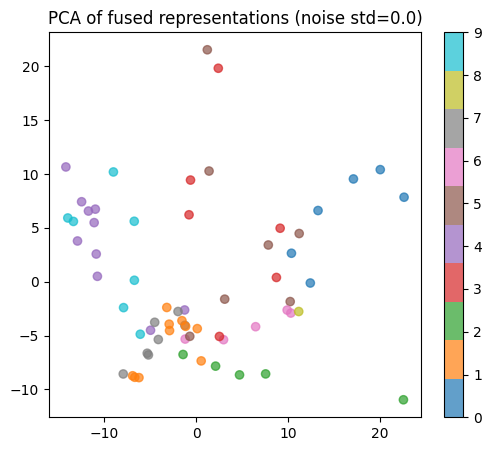


Training Concat Fusion Noise std=0.1...


Concat Fusion Noise std=0.1 Training: 100%|█| 5/5 [01:30<00:00, 18.14s/it, Train Acc=0.9700, Val Acc


Final Test: 0.1230 | Accuracy: 0.9651


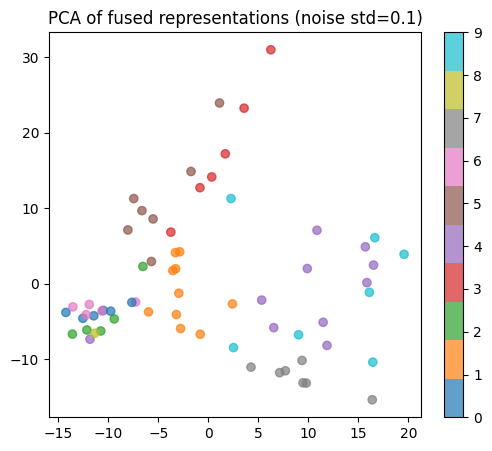


Training Concat Fusion Noise std=0.3...


Concat Fusion Noise std=0.3 Training: 100%|█| 5/5 [01:30<00:00, 18.08s/it, Train Acc=0.9674, Val Acc


Final Test: 0.1578 | Accuracy: 0.9539


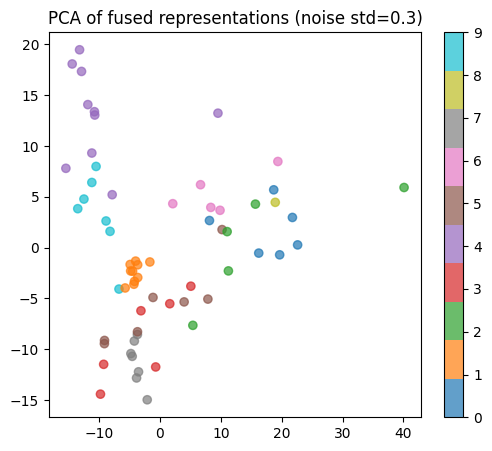


Training Concat Fusion Noise std=0.5...


Concat Fusion Noise std=0.5 Training: 100%|█| 5/5 [01:30<00:00, 18.19s/it, Train Acc=0.9637, Val Acc


Final Test: 0.1151 | Accuracy: 0.9646


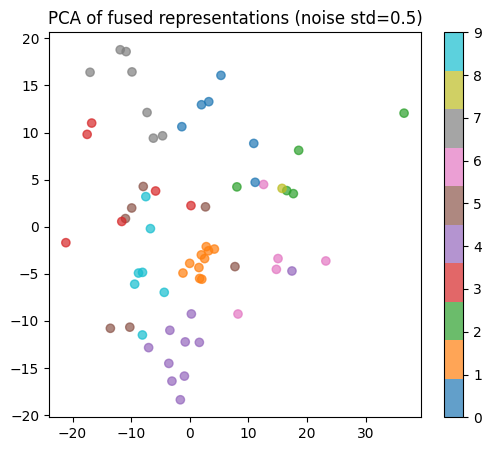

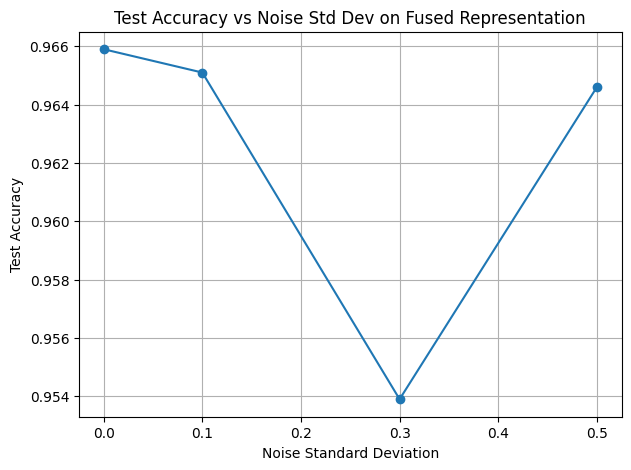

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np

class NoisyFusedModel(FusedModels):
    def __init__(self, noise_std=0.0):
        super().__init__('concat')
        self.noise_std = noise_std

    def forward(self, x):
        upper, lower = prepare_data(x)
        cnn_out = self.cnn_encoder(upper)  # [B, 10]
        mlp_out = self.mlp_encoder(lower)  # [B, 10]

        # Add Gaussian noise to representations
        if self.noise_std > 0:
            noise_cnn = torch.randn_like(cnn_out) * self.noise_std
            noise_mlp = torch.randn_like(mlp_out) * self.noise_std
            cnn_out = cnn_out + noise_cnn
            mlp_out = mlp_out + noise_mlp

        fused = torch.cat((cnn_out, mlp_out), dim=1)  # [B, 20]
        output = self.fusion.fc(fused)
        return output

    def get_fused_representation(self, x):
        # Return fused representation before classification layer
        upper, lower = prepare_data(x)
        cnn_out = self.cnn_encoder(upper)
        mlp_out = self.mlp_encoder(lower)
        if self.noise_std > 0:
            noise_cnn = torch.randn_like(cnn_out) * self.noise_std
            noise_mlp = torch.randn_like(mlp_out) * self.noise_std
            cnn_out = cnn_out + noise_cnn
            mlp_out = mlp_out + noise_mlp
        fused = torch.cat((cnn_out, mlp_out), dim=1)
        return fused.detach().cpu().numpy()

# Noise levels to test
noise_levels = [0.0, 0.1, 0.3, 0.5]

noise_results = []

for noise_std in noise_levels:
    model_name = f"Concat Fusion Noise std={noise_std}"
    model = NoisyFusedModel(noise_std=noise_std).to(device)

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    #print(f"\nTraining {model_name}...")
    epoch_bar = tqdm(range(num_epochs), desc=f"{model_name} Training", ncols=120)

    for epoch in epoch_bar:
        train_loss, train_acc = train_model(model, train_loader, optimizer, criterion)
        val_loss, val_acc = evaluate_model(model, val_loader, criterion)
        epoch_bar.set_postfix({"Train Acc": f"{train_acc:.4f}", "Val Acc": f"{val_acc:.4f}"})

    test_loss, test_acc = evaluate_model(model, test_loader, criterion)
    print(f"Final Test: {test_loss:.4f} | Accuracy: {test_acc:.4f}")
    noise_results.append({
        "Noise Std": noise_std,
        "Test Accuracy": test_acc,
        "Test Loss": test_loss
    })

    # Visualize fused representation from a small batch of test images
    model.eval()
    with torch.no_grad():
        images, labels = next(iter(test_loader))
        images = images.to(device)
        fused_repr = model.get_fused_representation(images)

    # Dimensionality reduction and plot
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(fused_repr)

    plt.figure(figsize=(6,5))
    scatter = plt.scatter(reduced[:,0], reduced[:,1], c=labels, cmap='tab10', alpha=0.7)
    plt.title(f"PCA of fused representations (noise std={noise_std})")
    plt.colorbar(scatter, ticks=range(10))
    plt.show()

# Plot noise vs accuracy
noise_stds = [r["Noise Std"] for r in noise_results]
accuracies = [r["Test Accuracy"] for r in noise_results]

plt.figure(figsize=(7,5))
plt.plot(noise_stds, accuracies, marker='o')
plt.title("Test Accuracy vs Noise Std Dev on Fused Representation")
plt.xlabel("Noise Standard Deviation")
plt.ylabel("Test Accuracy")
plt.grid(True)
plt.show()


## (vi) Self-supervised

In [ ]:
import random
# Seed everything for reproducibility
def seed_everything(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()

class CNNEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.flatten(x)
        return x

class MLPEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28 * 28, 256)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return F.relu(self.fc1(x))
    
class ProjectedEncoders(nn.Module):
    def __init__(self, projection_dim):
        super().__init__()
        self.cnn = CNNEncoder()
        self.mlp = MLPEncoder()
        self.project_cnn = nn.Linear(64 * 7 * 7, projection_dim)
        self.project_mlp = nn.Linear(256, projection_dim)

    def forward(self, x):
        upper, lower = prepare_data(x)
        z1 = self.project_cnn(self.cnn(upper))
        z2 = self.project_mlp(self.mlp(lower))
        return z1, z2

class ContrastiveLoss(nn.Module):
    def __init__(self, temperature=0.07):
        super().__init__()
        self.temperature = temperature

    def forward(self, z1, z2):
        z1 = F.normalize(z1, dim=1)
        z2 = F.normalize(z2, dim=1)
        batch_size = z1.size(0)
        logits = torch.matmul(z1, z2.T) / self.temperature
        labels = torch.arange(batch_size).to(device)
        return F.cross_entropy(logits, labels)

class LinearClassifier(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.fc = nn.Linear(in_dim, 10)

    def forward(self, x):
        return self.fc(x)

class CLIPPipeline:
    def __init__(self, projection_dim=128, lr=1e-3, epochs=5, temperature=0.07):
        self.model = ProjectedEncoders(projection_dim).to(device)
        self.loss_fn = ContrastiveLoss(temperature)
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.epochs = epochs
        self.linear_clf = None
        self.embeddings = {}

    def train(self, train_loader):
        print("\n>> Training CLIP-style alignment...")
        self.model.train()
        for epoch in range(self.epochs):
            total_loss = 0
            for x, _ in tqdm(train_loader, desc=f"CLIP Epoch {epoch+1}"):
                x = x.to(device)
                z1, z2 = self.model(x)
                loss = self.loss_fn(z1, z2)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                total_loss += loss.item()
            print(f"Epoch {epoch+1} - Loss: {total_loss / len(train_loader):.4f}")

    def extract_embeddings(self, train_loader, val_loader, test_loader):
        print("\n>> Extracting embeddings...")
        def _extract(loader):
            self.model.eval()
            zs, ys = [], []
            with torch.no_grad():
                for x, y in loader:
                    x = x.to(device)
                    z1, z2 = self.model(x)
                    z = (F.normalize(z1, dim=1) + F.normalize(z2, dim=1)) / 2
                    zs.append(z.cpu())
                    ys.append(y)
            return torch.cat(zs), torch.cat(ys)

        self.embeddings['train'] = _extract(train_loader)
        self.embeddings['val']   = _extract(val_loader)
        self.embeddings['test']  = _extract(test_loader)

    def train_classifier(self):
        print("\n>> Training linear classifier...")
        train_X, train_y = self.embeddings['train']
        val_X, val_y = self.embeddings['val']
        self.linear_clf = LinearClassifier(train_X.shape[1]).to(device)

        optimizer = optim.Adam(self.linear_clf.parameters(), lr=0.01)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(10):
            self.linear_clf.train()
            out = self.linear_clf(train_X.to(device))
            loss = criterion(out, train_y.to(device))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            with torch.no_grad():
                acc = (self.linear_clf(val_X.to(device)).argmax(1) == val_y.to(device)).float().mean()
            print(f"Epoch {epoch+1} | Loss: {loss.item():.4f} | Val Acc: {acc:.4f}")
    
    def evaluate(self):
        print("\n>> Evaluating on test set...")
        test_X, test_y = self.embeddings['test']
        self.linear_clf.eval()
        with torch.no_grad():
            preds = self.linear_clf(test_X.to(device)).argmax(1)
            acc = (preds == test_y.to(device)).float().mean()
        print(f"Test Accuracy: {acc:.4f}")

    def visualize(self):
        print("\n>> Visualizing embeddings...")
        test_X, test_y = self.embeddings['test']

        def _vis(method):
            if method == 'tsne':
                reduced = TSNE(n_components=2).fit_transform(test_X)
            elif method == 'pca':
                reduced = PCA(n_components=2).fit_transform(test_X)
            else:
                raise ValueError("Unknown method")

            plt.figure(figsize=(8, 6))
            plt.scatter(reduced[:, 0], reduced[:, 1], c=test_y, cmap='tab10', alpha=0.7)
            plt.colorbar()
            plt.title(f"{method.upper()} of Embeddings")
            plt.show()

        _vis('tsne')
        _vis('pca')

pipeline = CLIPPipeline(projection_dim=128, lr=0.001, epochs=5)
pipeline.train(train_loader)
pipeline.extract_embeddings(train_loader, val_loader, test_loader)
pipeline.train_classifier()
pipeline.evaluate()
pipeline.visualize()



>> Training CLIP-style alignment...


CLIP Epoch 1:   0%|          | 0/657 [00:00<?, ?it/s]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x3136 and 10x128)

## (vii) Alignment noise

In [ ]:
# Encoders and Projection
class CNNEncoder(nn.Module):
    def __init__(self):
        super(CNNEncoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = None

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)

        if self.fc1 is None:
            self.fc1 = nn.Linear(x.size(1), 10)
            self.fc1.to(x.device)

        x = self.fc1(x)
        return x

class MLPEncoder(nn.Module):
    def __init__(self):
        super(MLPEncoder, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x

def prepare_data(x):
    h = x.size(2)
    half = h // 2
    upper = F.pad(x[:, :, :half, :], (0, 0, 0, half))
    lower = F.pad(x[:, :, half:, :], (0, 0, half, 0))
    return upper, lower

class ProjectedEncoders(nn.Module):
    def __init__(self, projection_dim):
        super().__init__()
        self.cnn = CNNEncoder()
        self.mlp = MLPEncoder()
        self.project_cnn = nn.Linear(10, projection_dim)
        self.project_mlp = nn.Linear(10, projection_dim)

    def forward(self, x, noise_std=0.0):
        upper, lower = prepare_data(x)
        if noise_std > 0:
            upper += torch.randn_like(upper) * noise_std
            lower += torch.randn_like(lower) * noise_std
        z1 = self.project_cnn(self.cnn(upper))
        z2 = self.project_mlp(self.mlp(lower))
        return z1, z2

class ContrastiveLoss(nn.Module):
    def __init__(self, temperature=0.07):
        super().__init__()
        self.temperature = temperature

    def forward(self, z1, z2):
        z1 = F.normalize(z1, dim=1)
        z2 = F.normalize(z2, dim=1)
        batch_size = z1.size(0)
        logits = torch.matmul(z1, z2.T) / self.temperature
        labels = torch.arange(batch_size).to(device)
        return F.cross_entropy(logits, labels)

class LinearClassifier(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.fc = nn.Linear(in_dim, 10)

    def forward(self, x):
        return self.fc(x)

# CLIP Pipeline
class CLIPPipeline:
    def __init__(self, projection_dim=128, lr=1e-3, epochs=5, temperature=0.07):
        self.model = ProjectedEncoders(projection_dim).to(device)
        self.loss_fn = ContrastiveLoss(temperature)
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.epochs = epochs
        self.linear_clf = None
        self.embeddings = {}

    def train(self, train_loader):
        print("\n>> Training CLIP-style alignment...")
        self.model.train()
        for epoch in range(self.epochs):
            total_loss = 0
            for x, _ in tqdm(train_loader, desc=f"CLIP Epoch {epoch+1}"):
                x = x.to(device)
                z1, z2 = self.model(x)
                loss = self.loss_fn(z1, z2)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                total_loss += loss.item()
            print(f"Epoch {epoch+1} - Loss: {total_loss / len(train_loader):.4f}")

    def extract_embeddings(self, train_loader, val_loader, test_loader, noise_std=0.0):
        print("\n>> Extracting embeddings...")
        def _extract(loader):
            self.model.eval()
            zs, ys = [], []
            with torch.no_grad():
                for x, y in loader:
                    x = x.to(device)
                    z1, z2 = self.model(x, noise_std=noise_std)
                    z = (F.normalize(z1, dim=1) + F.normalize(z2, dim=1)) / 2
                    zs.append(z.cpu())
                    ys.append(y)
            return torch.cat(zs), torch.cat(ys)

        self.embeddings['train'] = _extract(train_loader)
        self.embeddings['val'] = _extract(val_loader)
        self.embeddings['test'] = _extract(test_loader)

    def train_classifier(self):
        print("\n>> Training linear classifier...")
        train_X, train_y = self.embeddings['train']
        val_X, val_y = self.embeddings['val']
        self.linear_clf = LinearClassifier(train_X.shape[1]).to(device)

        optimizer = optim.Adam(self.linear_clf.parameters(), lr=0.01)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(10):
            self.linear_clf.train()
            out = self.linear_clf(train_X.to(device))
            loss = criterion(out, train_y.to(device))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            with torch.no_grad():
                acc = (self.linear_clf(val_X.to(device)).argmax(1) == val_y.to(device)).float().mean()
            print(f"Epoch {epoch+1} | Loss: {loss.item():.4f} | Val Acc: {acc:.4f}")

    def evaluate(self):
        print("\n>> Evaluating on test set...")
        test_X, test_y = self.embeddings['test']
        self.linear_clf.eval()
        with torch.no_grad():
            preds = self.linear_clf(test_X.to(device)).argmax(1)
            acc = (preds == test_y.to(device)).float().mean()
        print(f"Test Accuracy: {acc:.4f}")

    def visualize(self):
        print("\n>> Visualizing embeddings...")
        test_X, test_y = self.embeddings['test']

        def _vis(method):
            if method == 'tsne':
                reduced = TSNE(n_components=2).fit_transform(test_X)
            elif method == 'pca':
                reduced = PCA(n_components=2).fit_transform(test_X)
            else:
                raise ValueError("Unknown method")

            plt.figure(figsize=(8, 6))
            plt.scatter(reduced[:, 0], reduced[:, 1], c=test_y, cmap='tab10', alpha=0.7)
            plt.colorbar()
            plt.title(f"{method.upper()} of Embeddings")
            plt.show()

        _vis('tsne')
        _vis('pca')

    def alignment_noise_analysis(self, loader, noise_levels=[0.0, 0.1, 0.2, 0.5]):
        print("\n>> Running alignment noise analysis...")
        for noise_std in noise_levels:
            print(f"\nNoise std: {noise_std}")
            self.extract_embeddings(train_loader, val_loader, loader, noise_std=noise_std)
            self.evaluate()
            self.visualize()

# Run the pipeline
if __name__ == '__main__':
    pipeline = CLIPPipeline(projection_dim=128, lr=0.001, epochs=5)
    pipeline.train(train_loader)
    pipeline.extract_embeddings(train_loader, val_loader, test_loader)
    pipeline.train_classifier()
    pipeline.evaluate()
    pipeline.visualize()
    pipeline.alignment_noise_analysis(test_loader)